In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Ensures that the display width isn't restricted
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('Network_anomaly_data.csv')
df['is_attack'] = df['attack'].apply(lambda x: 0 if x=='normal' else 1)
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [4]:
# land, wrongfragment,urgent, numfailedlogins,loggedin,rootshell,suattempted,numshells,ishostlogin,isguestlogin
df['land'] = df['land'].astype('category')
df['wrongfragment'] = df['wrongfragment'].astype('category')
df['urgent'] = df['urgent'].astype('category')
#df['numfailedlogins'] = df['numfailedlogins'].astype('category')
df['loggedin'] = df['loggedin'].astype('category')
df['rootshell'] = df['rootshell'].astype('category')
df['suattempted'] = df['suattempted'].astype('category')
df['numshells'] = df['numshells'].astype('category')
df['ishostlogin'] = df['ishostlogin'].astype('category')
df['isguestlogin'] = df['isguestlogin'].astype('category')

In [5]:
# Host count of flags
df['serror'] = df['count']*df['serrorrate']
df['rerror'] = df['count']*df['rerrorrate']

# Host srv count of flags
df['srvserror'] = df['srvcount']*df['srvrerrorrate']
df['srvrerror'] = df['srvcount']*df['srvserrorrate']

df['samesrv'] = df['count']*df['samesrvrate']
df['diffsrv'] = df['count']*df['diffsrvrate']

# Host count of flags
df['dsthostserror'] = df['dsthostcount']*df['dsthostserrorrate']
df['dsthostrerror'] = df['dsthostcount']*df['dsthostrerrorrate']

# Host srv count of flags
df['dsthostsrvserror'] = df['dsthostsrvcount']*df['dsthostsrvrerrorrate']
df['dsthostsrvrerror'] = df['dsthostsrvcount']*df['dsthostsrvserrorrate']

df['dsthostsamesrv'] = df['dsthostsrvcount']*df['dsthostsamesrvrate']
df['dsthostdiffsrv'] = df['dsthostsrvcount']*df['dsthostdiffsrvrate']

In [7]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
all_attacks = df['attack'].unique()

# Step 2: Create a stratified split ensuring that each category is in the test set at least once
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Split the data by each attack category and ensure they appear in test
for category in all_attacks:
    category_data = df[df['attack'] == category]

    if len(category_data) > 30:
        category_train, category_test = train_test_split(category_data, test_size=0.2,random_state=42)

    elif len(category_data) == 1:
        test_data = pd.concat([test_data,category_data])
        noise_data = category_data.copy()
        noise_data['count'] += 0.0001
        train_data = pd.concat([train_data,noise_data],axis=0)
        continue

    elif len(category_data) > 1 and len(category_data) <= 5:
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,1)
        test_selection = category_data[~category_data.index.isin(chooser)]
        train_selection = category_data[category_data.index.isin(chooser)]

        test_data = pd.concat([test_data,test_selection])
        train_data = pd.concat([train_data,train_selection])

        noise_data = train_selection.copy()
        noise_data['count'] += 0.0001
        train_data = pd.concat([train_data,noise_data],axis=0)
        continue
    
    elif len(category_data) > 5 and len(category_data) <= 10:
        #print('noise to',category)
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,3)
        test_selection = category_data[category_data.index.isin(chooser)]
        train_selection = category_data[~category_data.index.isin(chooser)]

        test_data = pd.concat([test_data,test_selection])
        train_data = pd.concat([train_data,train_selection])
        continue
    

    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)
    
    # Append to the train and test sets
    train_data = pd.concat([train_data,category_train])
    test_data = pd.concat([test_data,category_test])

In [8]:
X_train = train_data.drop(['attack','is_attack'],axis=1)
y_train = train_data['is_attack']
X_test = test_data.drop(['attack','is_attack'],axis=1)
y_test = test_data['is_attack']

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_columns = ['protocoltype', 'service', 'flag','land','wrongfragment','urgent','loggedin','rootshell','suattempted','numshells',
                       'ishostlogin','isguestlogin']

encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

In [10]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42,class_weight='balanced',n_estimators=100,
                            min_samples_split= 7,
                            max_features= 'sqrt',
                            max_depth= 30)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

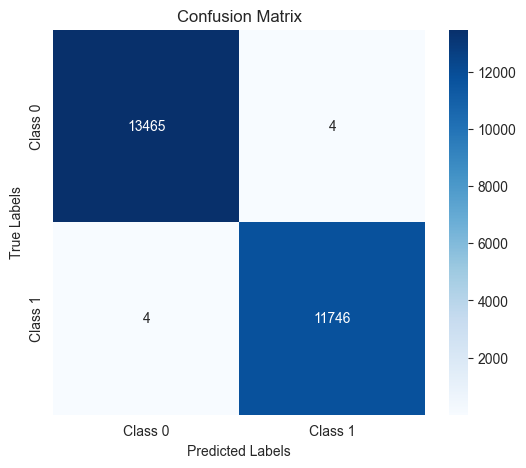

In [12]:
from sklearn.metrics import confusion_matrix


cmrf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cmrf, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
y_pred_df = pd.DataFrame(y_pred_rf,index=y_test.index)
y_pred_df.isna().sum()

0    0
dtype: int64

In [14]:
combined_pred = pd.concat([y_test,y_pred_df],axis=1)
combined_pred.columns = ['is_attack','is_attack_pred']
predicted_probabilities = rf.predict_proba(X_test)
combined_pred['predict_prob'] = predicted_probabilities[:, 1]
combined_pred.head()

,is_attack,is_attack_pred,predict_prob
18091,0,0,0.0
29741,0,0,0.0
76709,0,0,0.0
91928,0,0,0.0
39962,0,0,0.0


In [15]:
combined_pred_eq = combined_pred[combined_pred['is_attack'] == combined_pred['is_attack_pred']]
combined_pred_uneq = combined_pred[combined_pred['is_attack'] != combined_pred['is_attack_pred']]
combined_pred_uneq = combined_pred_uneq[combined_pred_uneq['is_attack'] == 1]
combined_pred = pd.concat([combined_pred_eq,combined_pred_uneq],axis=0)
combined_pred.shape

(25215, 3)

In [16]:
op = pd.merge(X_test,combined_pred,left_index=True,right_index=True)
op = pd.merge(op,df[['attack']],left_index=True,right_index=True)
op.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,is_attack,is_attack_pred,predict_prob,attack
18091,-0.109310,2.223247,-1.176121,0.751235,-0.007738,-0.005282,-0.013733,-0.091207,-0.007426,-0.095657,-0.026347,-0.810621,-0.021129,-0.036764,-0.025728,-0.021314,-0.026258,-0.018455,-0.040422,0.0,-0.00315,-0.097769,0.182993,2.168315,-0.637508,-0.632041,-0.374377,-0.374536,0.770813,-0.349275,-0.336050,0.736037,1.258282,1.066428,-0.438895,-0.479522,-0.288570,-0.639306,-0.624801,-0.387847,-0.376424,-0.656686,-0.540977,-0.251738,-0.242117,-0.503684,1.161685,-0.196049,-0.62548,-0.343026,-0.173353,-0.418809,1.304689,-0.292250,0,0,0.0,normal
29741,-0.109310,-0.124694,-0.442344,0.751235,-0.007699,-0.002285,-0.013733,-0.091207,-0.007426,-0.095657,-0.026347,1.233623,-0.021129,-0.036764,-0.025728,-0.021314,-0.026258,-0.018455,-0.040422,0.0,-0.00315,-0.097769,-0.585893,-0.148030,-0.637508,-0.632041,-0.374377,-0.374536,0.770813,-0.349275,-0.374559,0.736037,1.258282,1.066428,-0.438895,-0.479522,-0.288570,-0.639306,-0.624801,-0.387847,-0.376424,0.654444,-0.540977,-0.251738,-0.242117,-0.503684,-0.099828,-0.196049,-0.62548,-0.343026,-0.173353,-0.418809,1.304689,-0.292250,0,0,0.0,normal
76709,-0.109310,2.223247,-1.176121,0.751235,-0.007741,-0.005290,-0.013733,-0.091207,-0.007426,-0.095657,-0.026347,-0.810621,-0.021129,-0.036764,-0.025728,-0.021314,-0.026258,-0.018455,-0.040422,0.0,-0.00315,-0.097769,-0.725690,-0.368634,-0.637508,-0.632041,-0.374377,-0.374536,0.770813,-0.349275,-0.374559,-1.379012,0.734390,1.066428,-0.438895,2.765734,-0.199832,-0.639306,-0.624801,-0.387847,-0.376424,0.654444,-0.540977,-0.251738,-0.242117,-0.503684,-0.329193,-0.196049,-0.62548,-0.343026,-0.173353,-0.418809,0.800660,-0.292250,0,0,0.0,normal
91928,-0.109310,2.223247,1.086357,0.751235,-0.007729,-0.005277,-0.013733,-0.091207,-0.007426,-0.095657,-0.026347,-0.810621,-0.021129,-0.036764,-0.025728,-0.021314,-0.026258,-0.018455,-0.040422,0.0,-0.00315,-0.097769,-0.673266,-0.368634,-0.637508,-0.632041,-0.374377,-0.374536,-1.185460,1.260422,-0.374559,0.736037,1.204086,1.021869,-0.385953,-0.479522,-0.288570,-0.639306,-0.624801,-0.387847,-0.376424,-0.656686,-0.540977,-0.251738,-0.242117,-0.503684,-0.329480,-0.155956,-0.62548,-0.343026,-0.173353,-0.418809,1.209271,0.212258,0,0,0.0,normal
39962,-0.098889,2.223247,-1.176121,0.751235,-0.007741,-0.005303,-0.013733,-0.091207,-0.007426,-0.095657,-0.026347,-0.810621,-0.021129,-0.036764,-0.025728,-0.021314,-0.026258,-0.018455,-0.040422,0.0,-0.00315,-0.097769,-0.708215,-0.313483,-0.637508,-0.632041,-0.374377,-0.374536,-0.753260,3.369680,1.165796,-1.207794,-0.755990,-0.002982,-0.174187,-0.414617,-0.288570,-0.639306,-0.624801,-0.387847,-0.376424,0.654444,-0.540977,-0.251738,-0.242117,-0.503684,-0.329337,-0.156351,-0.62548,-0.343026,-0.173353,-0.418809,-0.766696,0.031932,0,0,0.0,normal


In [27]:
attacks = op[np.logical_or(op['is_attack_pred'] == 1,np.logical_or(op['is_attack_pred'] == 1,op['is_attack'] == 1))].copy()
attacks.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,is_attack,is_attack_pred,predict_prob,attack
25445,-0.10931,-0.124694,1.086357,-0.735746,-0.007745,-0.00531,-0.013733,-0.091207,-0.007426,-0.095657,-0.026347,-0.810621,-0.021129,-0.036764,-0.025728,-0.021314,-0.026258,-0.018455,-0.040422,0.0,-0.00315,-0.097769,1.100413,-0.327271,1.602008,1.604973,-0.374377,-0.374536,-1.458428,-0.016234,-0.374559,0.736037,-1.008903,-1.116951,-0.068304,-0.479522,-0.28857,1.609093,1.618990,-0.387847,-0.376424,0.654444,1.861680,-0.251738,-0.242117,0.157647,-0.283320,0.052804,1.655744,-0.343026,-0.173353,-0.020287,-0.910605,-0.235518,1,1,1.0,neptune
71233,-0.10931,-0.124694,1.453245,-0.735746,-0.007745,-0.00531,-0.013733,-0.091207,-0.007426,-0.095657,-0.026347,-0.810621,-0.021129,-0.036764,-0.025728,-0.021314,-0.026258,-0.018455,-0.040422,0.0,-0.00315,-0.097769,1.275160,-0.299695,1.602008,1.604973,-0.374377,-0.374536,-1.435681,-0.016234,-0.374559,0.736037,-0.873414,-1.005554,-0.121245,-0.479522,-0.28857,1.609093,1.618990,-0.387847,-0.376424,0.217400,2.090504,-0.251738,-0.242117,0.488312,-0.244615,0.076504,1.655744,-0.343026,-0.173353,1.474173,-0.899742,-0.061270,1,1,1.0,neptune
30788,-0.10931,-0.124694,1.086357,-2.222727,-0.007745,-0.00531,-0.013733,-0.091207,-0.007426,-0.095657,-0.026347,-0.810621,-0.021129,-0.036764,-0.025728,-0.021314,-0.026258,-0.018455,-0.040422,0.0,-0.00315,-0.097769,1.187787,-0.313483,-0.637508,-0.632041,2.746180,2.713674,-1.458428,0.039273,-0.374559,0.736037,-0.999871,-1.116951,-0.068304,-0.479522,-0.28857,-0.639306,-0.624801,2.873455,2.754375,0.654444,-0.540977,3.211312,1.514909,-0.503684,-0.280453,0.108105,-0.625480,3.321313,0.002507,-0.418809,-0.910431,-0.221335,1,1,1.0,neptune
30951,-0.10931,-0.124694,1.086357,-2.222727,-0.007745,-0.00531,-0.013733,-0.091207,-0.007426,-0.095657,-0.026347,-0.810621,-0.021129,-0.036764,-0.025728,-0.021314,-0.026258,-0.018455,-0.040422,0.0,-0.00315,-0.097769,0.174256,-0.368634,-0.637508,-0.632041,2.746180,2.713674,-1.481176,0.150286,-0.374559,0.736037,-1.036001,-1.161510,0.037579,-0.479522,-0.28857,-0.639306,-0.624801,2.873455,2.754375,0.654444,-0.540977,1.385340,0.109288,-0.503684,-0.328620,-0.011187,-0.625480,3.321313,-0.138181,-0.418809,-0.911300,-0.274014,1,1,1.0,neptune
111798,-0.10931,-0.124694,1.086357,-2.222727,-0.007745,-0.00531,-0.013733,-0.091207,-0.007426,-0.095657,-0.026347,-0.810621,-0.021129,-0.036764,-0.025728,-0.021314,-0.026258,-0.018455,-0.040422,0.0,-0.00315,-0.097769,0.934404,-0.285908,-0.637508,-0.632041,2.746180,2.713674,-1.412933,0.039273,-0.374559,0.736037,-0.981805,-1.094671,-0.015362,-0.479522,-0.28857,-0.639306,-0.624801,2.873455,2.754375,0.654444,-0.540977,2.754819,2.217720,-0.503684,-0.234007,0.068012,-0.625480,3.321313,0.072851,-0.418809,-0.909475,-0.178786,1,1,1.0,neptune


In [28]:
acount = attacks['attack'].value_counts().reset_index()
specials = set(acount[acount['count'] <= 3]['attack'])
specials

{'ftp_write', 'loadmodule', 'multihop', 'perl', 'phf', 'rootkit', 'spy'}

In [29]:
attacks['nattack'] = attacks['attack'].apply(lambda x: 'other' if x in specials else x)

In [31]:
Xheavy = attacks.drop(['attack','nattack'],axis=1)
yheavy = attacks['nattack']

X1_train,X1_test,y1_train,y1_test = train_test_split(Xheavy,yheavy,stratify=yheavy,test_size=0.2)

In [32]:
target_encoder = LabelEncoder()
y1_train_encoded = target_encoder.fit_transform(y1_train)
y1_test_encoded = target_encoder.transform(y1_test)

In [33]:
rf2 = RandomForestClassifier(random_state=42,class_weight='balanced',
                             n_estimators=150,max_depth=20,
                             min_samples_split=10,max_features='log2')
rf2.fit(X1_train,y1_train_encoded)
y_pred1 = rf2.predict(X1_test)

In [34]:
target_classes = [target_encoder.classes_[i] for i in range(len(target_encoder.classes_))]
len(target_classes)

16

<Axes: >

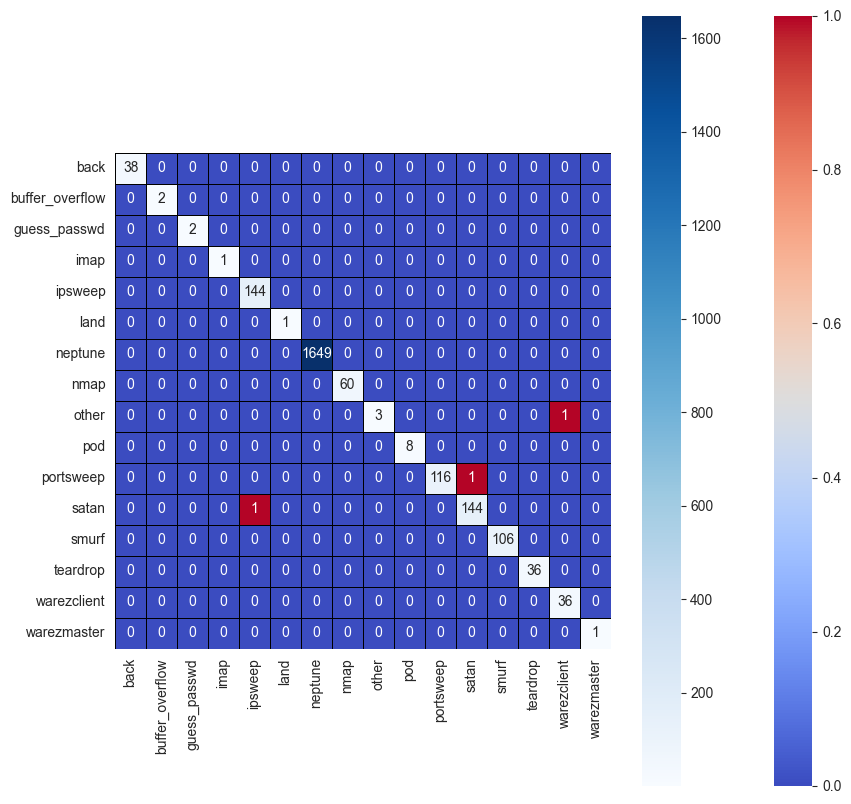

In [35]:
cmbestrf = confusion_matrix(y1_test_encoded, y_pred1)

cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmbestrf.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cmbestrf, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmbestrf, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes) 

In [36]:
from sklearn.model_selection import RandomizedSearchCV


param_dist = {
    'n_estimators': [50,100, 150,200,300],
    'max_depth': [None, 10, 20,30,40],
    'min_samples_split': [2, 5, 7,10],
    'max_features': ['sqrt', 'log2', None]
}


rf_model = RandomForestClassifier(random_state=42,class_weight='balanced')
random_search_dos = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=500, cv=5, scoring='accuracy', 
                                   n_jobs=-1, random_state=42)
random_search_dos.fit(X1_train, y1_train_encoded)
random_search_dos.best_params_

d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 300 is smaller than n_iter=500. Running 300 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_estimators': 100,
 'min_samples_split': 5,
 'max_features': 'sqrt',
 'max_depth': None}

<Axes: >

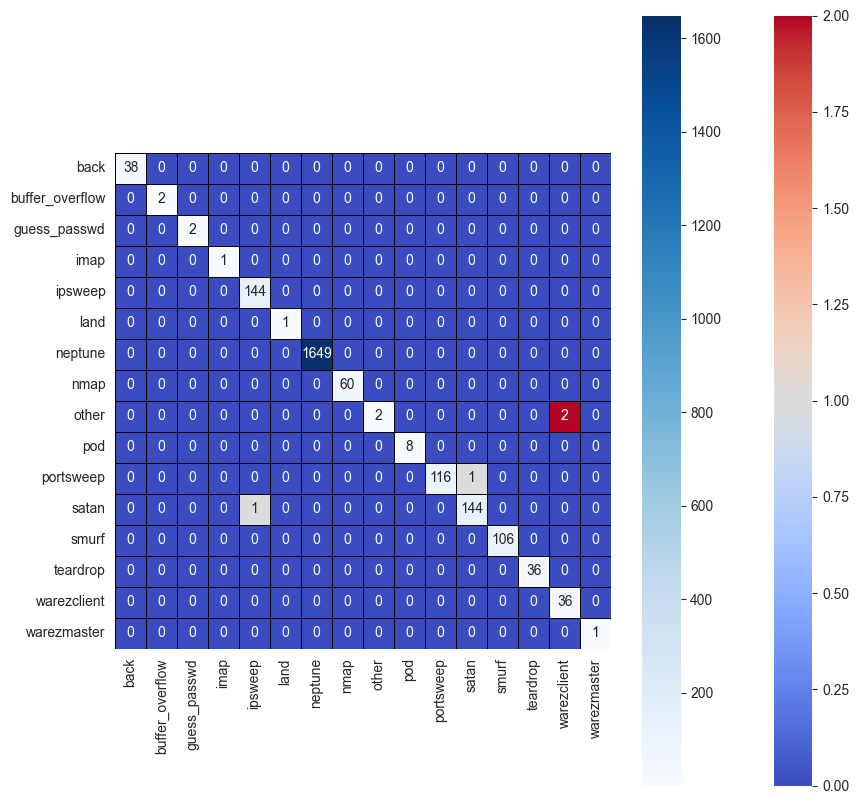

In [39]:
best_dos = random_search_dos.best_estimator_
y_pred_dos_best = best_dos.predict(X1_test)

cmbestrf = confusion_matrix(y1_test_encoded, y_pred_dos_best)

cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmbestrf.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cmbestrf, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmbestrf, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes) 

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y1_test_encoded,y_pred_dos_best,target_names=target_classes))

                 precision    recall  f1-score   support

           back       1.00      1.00      1.00        38
buffer_overflow       1.00      1.00      1.00         2
   guess_passwd       1.00      1.00      1.00         2
           imap       1.00      1.00      1.00         1
        ipsweep       0.99      1.00      1.00       144
           land       1.00      1.00      1.00         1
        neptune       1.00      1.00      1.00      1649
           nmap       1.00      1.00      1.00        60
          other       1.00      0.50      0.67         4
            pod       1.00      1.00      1.00         8
      portsweep       1.00      0.99      1.00       117
          satan       0.99      0.99      0.99       145
          smurf       1.00      1.00      1.00       106
       teardrop       1.00      1.00      1.00        36
    warezclient       0.95      1.00      0.97        36
    warezmaster       1.00      1.00      1.00         1

       accuracy              

In [99]:
odf = attacks[attacks['nattack'] == 'other'].copy()
odf.shape

(18, 59)

In [100]:
odf = odf[~odf['attack'].isin(['spy','perl'])]

In [101]:
all_attacks2 = odf['attack'].unique()
np.random.seed(42)

# Step 2: Create a stratified split ensuring that each category is in the test set at least once
train2_data = pd.DataFrame()
test2_data = pd.DataFrame()

# Split the data by each attack category and ensure they appear in test
for category in all_attacks2:
    # Get data for the current category
    category_data = attacks[attacks['attack'] == category]
    all_idx = category_data.index
    chooser = np.random.choice(all_idx,2)
    test2_data = pd.concat([test2_data,category_data[~category_data.index.isin(chooser)]])
    train2_data = pd.concat([train2_data,category_data[category_data.index.isin(chooser)]])

In [102]:
X2_train = train2_data.drop(['attack','is_attack','nattack'],axis=1)
y2_train = train2_data['attack']
X2_test = test2_data.drop(['attack','is_attack','nattack'],axis=1)
y2_test = test2_data['attack']

In [103]:
X2_train.drop(['is_attack_pred', 'predict_prob'],axis=1,inplace=True)
X2_test.drop(['is_attack_pred', 'predict_prob'],axis=1,inplace=True)

In [104]:
target_encoder_2 = LabelEncoder()
y2_train_encoded = target_encoder_2.fit_transform(y2_train)
y2_test_encoded = target_encoder_2.transform(y2_test)

In [105]:
target_classes2 = [target_encoder_2.classes_[i] for i in range(len(target_encoder_2.classes_))]
target_classes2

['ftp_write', 'loadmodule', 'multihop', 'phf', 'rootkit']

In [106]:
ros_dict = dict()
smote_dict = dict()

for i in range(len(target_encoder_2.classes_)):
    ros_dict[i] = 8
    smote_dict[i] = 100

In [107]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(sampling_strategy=ros_dict,random_state=42)
X2_train_resampled, y2_train_resampled = ros.fit_resample(X2_train, y2_train_encoded)

smote = SMOTE(sampling_strategy=smote_dict,random_state=42)
X2_train_smote, y2_train_smote = smote.fit_resample(X2_train_resampled, y2_train_resampled)

In [108]:
rf3 = RandomForestClassifier(random_state=42)
rf3.fit(X2_train, y2_train_encoded)
y_pred3 = rf3.predict(X2_test)

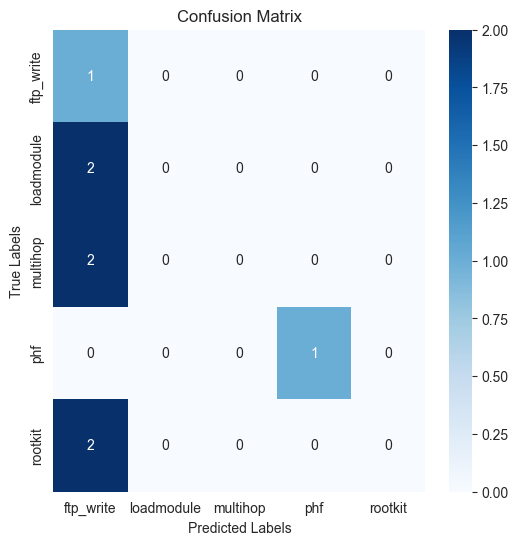

In [109]:
cmref2 = confusion_matrix(y2_test_encoded, y_pred3)
plt.figure(figsize=(6, 6))
sns.heatmap(cmref2, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes2, yticklabels=target_classes2)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [110]:
from sklearn.model_selection import RandomizedSearchCV


param_dist = {
    'n_estimators': [50,100, 150,200],
    'max_depth': [None, 10, 20,30,40],
    'min_samples_split': [2, 5, 7,10],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=500, cv=5, scoring='accuracy', 
                                   n_jobs=-1, random_state=42)
random_search.fit(X2_train_smote, y2_train_smote)
random_search.best_estimator_

d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 240 is smaller than n_iter=500. Running 240 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForestClassifier(n_estimators=50, random_state=42)

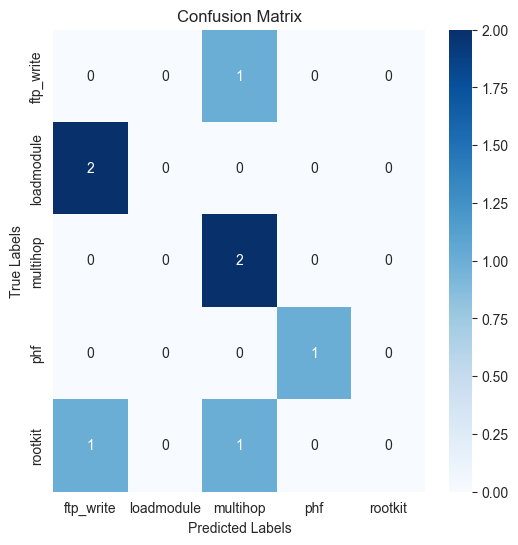

In [111]:
best_rf = random_search.best_estimator_
y_pred_rf_best = best_rf.predict(X2_test)
from sklearn.metrics import confusion_matrix

cmbestrf = confusion_matrix(y2_test_encoded, y_pred_rf_best)

plt.figure(figsize=(6, 6))
sns.heatmap(cmbestrf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes2, yticklabels=target_classes2)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()